In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 256
NUM_WORKERS = 8
WIDTH, HEIGHT = 28, 28

In [3]:
mnist_train = datasets.MNIST(root="./datasets/", train=True, transform=torchvision.transforms.ToTensor(), download=False)
mnist_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

In [4]:
# define generator class
class Generator(nn.Module):
    def __init__(self, width, height):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, width * height)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    

# define discriminator
class Discriminator(nn.Module):
    def __init__(self, width, height):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(width * height, 256)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
g = Generator(WIDTH, HEIGHT).to(device)
g = g.train()

d = Discriminator(WIDTH, HEIGHT).to(device)
d = d.train()

In [7]:
loss = F.binary_cross_entropy

In [8]:
g_optimizer = optim.Adam(g.parameters(), lr=1e-4)
d_optimizer = optim.Adam(d.parameters(), lr=1e-4)

In [9]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epoch #0


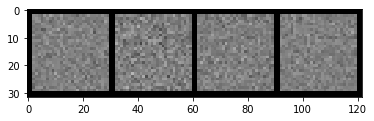

Epoch #50


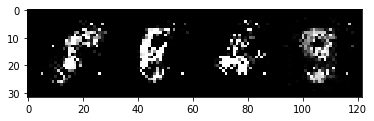

Epoch #100


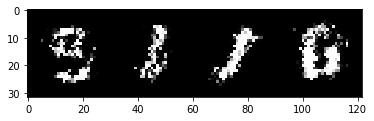

Epoch #150


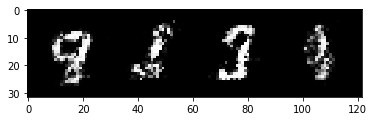

Epoch #200


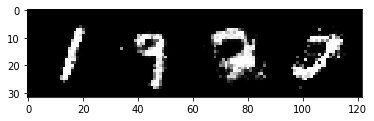

Epoch #250


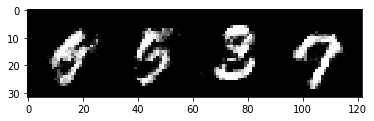

Epoch #300


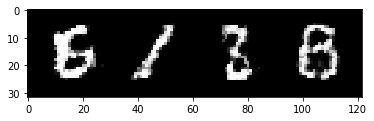

Epoch #350


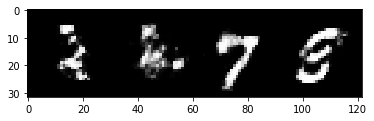

Epoch #400


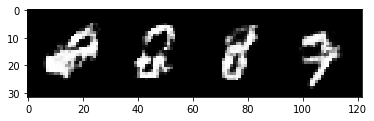

In [10]:
for epoch in range(401):
    if epoch % 50 == 0:
        print("Epoch #%d" % (epoch, ))
        
        g.eval()
        with torch.no_grad():
            Z = torch.randn(4, 128).to(device)
            imgs = g(Z)
            imshow(make_grid(imgs.reshape(4, 1, 28, 28)))
        g.train()
            
    for i, (X, _) in enumerate(mnist_loader):
        # send input to device
        X = X.reshape(X.shape[0], -1).to(device)
        
        # sample gausian noise
        Z = torch.randn(BATCH_SIZE, 128, device=device)
        
        # labels for BCEloss
        labels = torch.ones((BATCH_SIZE, 1), device=device)
        
        # compute loss for discriminator and update params
        d_optimizer.zero_grad()
        with torch.no_grad():
            fake = g(Z)        
        d_loss = loss(d(X), labels) + loss(1 - d(fake), labels)
        d_loss.backward()
        d_optimizer.step()
        
        
        # compute loss for generator and update params
        Z = torch.randn(BATCH_SIZE, 128, device=device)
        g_optimizer.zero_grad()
        g_loss = loss(d(g(Z)), labels)
        g_loss.backward()
        g_optimizer.step()
        